# Consumer Finance Complaints 
## Multicategorical classification for product categories
### Edimah SONGO


These are real world complaints received about financial products and services. Each complaint has been labeled with a specific product; therefore, this is a supervised text classification problem. With the aim to classify future complaints based on its content, you can use different deep learning algorithms to make predictions (i.e., classify the complaint in one of the product categories)

In [1]:
import pandas as pd
data1 = pd.read_csv("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/consumer_complaints1.csv")
data2 = pd.read_csv("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/consumer_complaints2.csv")
data3 = pd.read_csv("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/consumer_complaints3.csv")
data4 = pd.read_csv("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/consumer_complaints4.csv")

complaints = pd.concat([data1,data2,data3,data4], axis=0, ignore_index=True)
complaints.head(3)

,level_0,index,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,0,190126,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
1,1,190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
2,2,190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524


The goal here is to design some deep learning algorithms that classify complaints in one each product categories. In the following, we will be designing four different models and compare their performances using various metrics :
- Convolutional Neural Networks
- Recurrent Neural Networks
  - Single-layer LSTM
  - Bidirectional LSTM
- Transformer Pre-trained on BERT

Once all the models have been trained and compared with the usual metrics, we will be using them to predict the category of a brand new complaint.

**Remark** : In the exportation, we've noticed that the `concat` method leads to indices appearing four times in the new `complaints` Dataframe. So we set the `ignore_index` to True.

# Exploratory Data Analysis (EDA)

Here, we gain insights into our data through the distribution of complaint categories, the length of the complaints, and the most frequent words used in the complaints.


* **Word Cloud**: visualise the most frequent words used in the issues columns to get an idea of the most common problems customers are facing. You can use Python's wordcloud library for this.
* **Distribution of product categories** : get an idea of how balanced the complaints are.


### Basic summary statistics and counts

In [2]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   level_0                       66806 non-null  int64 
 1   index                         66806 non-null  int64 
 2   date_received                 66806 non-null  object
 3   product                       66806 non-null  object
 4   sub_product                   46351 non-null  object
 5   issue                         66806 non-null  object
 6   sub_issue                     32932 non-null  object
 7   consumer_complaint_narrative  66806 non-null  object
 8   company_public_response       32776 non-null  object
 9   company                       66806 non-null  object
 10  state                         66620 non-null  object
 11  zipcode                       66617 non-null  object
 12  tags                          11417 non-null  object
 13  consumer_consent

In [3]:
print("Product categories : ", complaints['product'].unique())

num_classes = len(complaints['product'].unique())
print("Number of product categories : ", num_classes)

Product categories :  ['Debt collection' 'Consumer Loan' 'Mortgage' 'Credit card'
 'Credit reporting' 'Student loan' 'Bank account or service' 'Payday loan'
 'Money transfers' 'Other financial service' 'Prepaid card']
Number of product categories :  11


There are 66806 rows and no null-values for the "product", "issues", and "consumer_complaint_narrative" columns. 

Additionally there are exactly 11 product categories.

### Distribution of product categories

<AxesSubplot:xlabel='product', ylabel='count'>

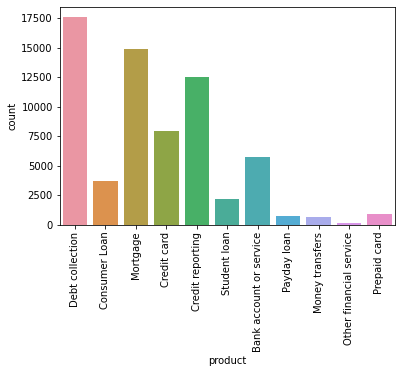

In [4]:
import seaborn as sns
dist = sns.countplot(x='product',data=complaints)
dist.set_xticklabels(dist.get_xticklabels(), rotation=90)
dist

The distributions are somewhat imbalanced, which might affect the performance of our deep learning models with majority categories being over-represented. 

We later use this information to pick a parameter when computing predictions with our transformer model.

### Word cloud : most common issues

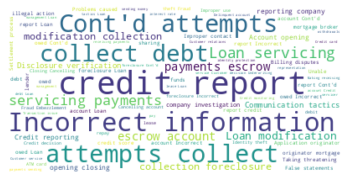

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = ' '.join(complaints['issue'].astype(str).tolist())

wordcloud = WordCloud(background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Data preprocessing



## Text preprocessing 

### Merge columns of interest into one



Both the "issue" and "consumer_complaint_narrative" columns contain text info from the consumer. We merge them into one column "whole_complaint" that we will then use for text mining.

In [6]:
complaints['whole_complaint'] = complaints['issue'] + ". " + complaints['consumer_complaint_narrative']

complaints['whole_complaint'].head()

0    Cont'd attempts collect debt not owed. XXXX ha...
1    Managing the loan or lease. Due to inconsisten...
2    Loan modification,collection,foreclosure. In X...
3    Loan servicing, payments, escrow account. I ha...
4    Credit decision / Underwriting. XXXX was submi...
Name: whole_complaint, dtype: object

### Clean the data

First, we notice that the text data is relatively clean of noisy symbols, save for occasional "\n". 


In [7]:
complaints['whole_complaint'][25]

'Incorrect information on credit report. I have submitted XXXX disputes to Trans Union credit bureau regarding incorrect payment history for an account on my report - XXXX. The payment history reflects multiple late payments when in fact the account was paid in a timely manner. I have also contacted the creditor but no answer has been given after numerous attempts. I am not sure what else to do given the attempts and lack of proper response from the credit bureau. \n'


Now, using the modified `clean_text` function from the text_mining_with_CNN assignnment we clean the newly formed column.

In [8]:
import re
def clean_text(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    data=data.replace("\n", " ")
    return data

In [9]:
complaints['whole_complaint'] = complaints['whole_complaint'].apply(lambda x:clean_text(x).lower())

We can check again our example for any undesirable symbol and move on.

In [10]:
complaints['whole_complaint'][25]

'incorrect information on credit report i have submitted xxxx disputes to trans union credit bureau regarding incorrect payment history for an account on my report  xxxx the payment history reflects multiple late payments when in fact the account was paid in a timely manner i have also contacted the creditor but no answer has been given after numerous attempts i am not sure what else to do given the attempts and lack of proper response from the credit bureau  '

## Encoding the target values

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(complaints['product'].unique())

complaints['encoded_target'] = le.transform(complaints['product'])

## Vectorising the text

Here we tokenize and vectorize our data so we can use it in our Deep Learning models.



In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

X_token = [d.split() for d in list(complaints['whole_complaint'])]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_token)
X = tokenizer.texts_to_sequences(X_token)

vocab_size = len(tokenizer.word_index)+1

Now we refer to a histogram of the length of each complaint to decide what the best truncation would be for better performance.

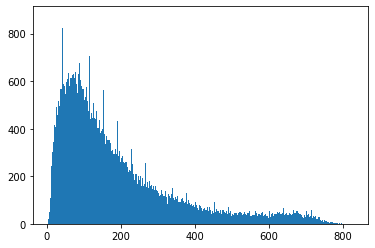

In [13]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in X],bins=400)
plt.show()

Notice that most complaints have a word count of less than 400, we decide to use `pad_sequence` to truncate and pad the text data. This will help ensure that all inputs have the same length and can be fed into the model without issues.

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 400

X = pad_sequences(X, maxlen=max_length, padding='post')

## Train/test set split

In [15]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X,complaints['encoded_target'].values,test_size=0.20, random_state=42)

# We apply one hot encoding to the datasets
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Model architectures

In the following, we develop four different model architectures to classify the complaints.

## Convolutional Neural Network (CNN)

Our first model is a CNN, comprising of :
- An embedding layer,
- 3 convolution layers so it can pick up on more subtle nuances in the text,
- 2 dropout layers throughout to avoid overfitting,
- A global max pooling layer in order to pick up on the most important information in the text (as opposed to an average, as with "average pooling")


Since we are dealing with multicategorical classification, the last dense layer gives the same number of outputs as the number of classes, and we can use softmax as the activation function. 

Our model will output a probability for each possible product category. In that spirit, we also use the categorical cross-entropy as a loss function.

We compile this model with an ADAM optimizer, a binary_crossentropy loss function and the "accuracy" metric.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout

embedding_dim = 100
num_filters = 128
filter_size = 5

model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_cnn.add(Conv1D(num_filters, filter_size, activation='relu'))
model_cnn.add(Conv1D(num_filters, filter_size, activation='relu')) # stacking Convolutions to better capture complex patterns
model_cnn.add(Dropout(rate=0.1))
model_cnn.add(Conv1D(num_filters, filter_size, activation='relu'))
model_cnn.add(GlobalMaxPooling1D()) # max pooling to focus on the most important features
model_cnn.add(Flatten())
model_cnn.add(Dropout(rate=0.1))
model_cnn.add(Dense(num_classes, activation='softmax'))

model_cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) 

In [17]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          6771800   
                                                                 
 conv1d (Conv1D)             (None, 396, 128)          64128     
                                                                 
 conv1d_1 (Conv1D)           (None, 392, 128)          82048     
                                                                 
 dropout (Dropout)           (None, 392, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 388, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                        

In [18]:
history_cnn = model_cnn.fit(X_train, y_train,epochs=5,validation_split=0.1)

Epoch 1/5
1504/1504 [==============================] - 99s 60ms/step - loss: 0.4126 - accuracy: 0.8648 - val_loss: 0.1439 - val_accuracy: 0.9560
Epoch 2/5
1504/1504 [==============================] - 28s 19ms/step - loss: 0.1158 - accuracy: 0.9653 - val_loss: 0.1232 - val_accuracy: 0.9654
Epoch 3/5
1504/1504 [==============================] - 22s 15ms/step - loss: 0.0693 - accuracy: 0.9796 - val_loss: 0.1276 - val_accuracy: 0.9680
Epoch 4/5
1504/1504 [==============================] - 22s 15ms/step - loss: 0.0454 - accuracy: 0.9869 - val_loss: 0.1497 - val_accuracy: 0.9652
Epoch 5/5
1504/1504 [==============================] - 22s 15ms/step - loss: 0.0327 - accuracy: 0.9908 - val_loss: 0.1534 - val_accuracy: 0.9650


In [19]:
model_cnn.evaluate(X_test, y_test)

418/418 [==============================] - 2s 5ms/step - loss: 0.1381 - accuracy: 0.9670


[0.1381445825099945, 0.9669959545135498]

## Recurrent Neural Network : Long Short-Term Memory (LSTM)

### Single-layer LSTM

In [20]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_lstm.add(LSTM(units=128))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) 

In [21]:
history_lstm = model_lstm.fit(X_train, y_train,epochs=5,validation_split=0.1)

Epoch 1/5
1504/1504 [==============================] - 81s 52ms/step - loss: 1.8815 - accuracy: 0.2900 - val_loss: 1.8767 - val_accuracy: 0.2804
Epoch 2/5
1504/1504 [==============================] - 33s 22ms/step - loss: 1.0184 - accuracy: 0.5898 - val_loss: 1.0074 - val_accuracy: 0.6260
Epoch 3/5
1504/1504 [==============================] - 30s 20ms/step - loss: 0.7383 - accuracy: 0.6831 - val_loss: 0.6310 - val_accuracy: 0.7373
Epoch 4/5
1504/1504 [==============================] - 29s 19ms/step - loss: 0.5196 - accuracy: 0.7895 - val_loss: 0.4690 - val_accuracy: 0.7985
Epoch 5/5
1504/1504 [==============================] - 28s 19ms/step - loss: 0.2613 - accuracy: 0.9094 - val_loss: 0.2747 - val_accuracy: 0.9083


We can notice that the LSTM model might require more epochs than our CNN to reach validation accuracies greater than 95% : the first epoch ouputs a low validation set accuracy, whereas our CNN starts off with a much higher one in its early training epochs.

In [22]:
model_lstm.evaluate(X_test, y_test)

418/418 [==============================] - 3s 7ms/step - loss: 0.2821 - accuracy: 0.9092


[0.28206199407577515, 0.9092201590538025]

We have chosen to set the number of neurons to 128, as 64 and 256 had worse performances.

### Bidirectional LSTM

Using a bidirectional model able to use information from both the past and the future might improve our performances.

In [23]:
from keras.layers import Bidirectional

model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_length))
model_bilstm.add(Bidirectional(LSTM(units=128)))
model_bilstm.add(Dense(num_classes,activation='softmax'))

model_bilstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) 

In [24]:
history_bilstm = model_bilstm.fit(X_train, y_train,epochs=5, validation_split=0.1)

Epoch 1/5
1504/1504 [==============================] - 99s 63ms/step - loss: 0.2981 - accuracy: 0.9113 - val_loss: 0.1684 - val_accuracy: 0.9459
Epoch 2/5
1504/1504 [==============================] - 52s 35ms/step - loss: 0.1337 - accuracy: 0.9583 - val_loss: 0.1578 - val_accuracy: 0.9514
Epoch 3/5
1504/1504 [==============================] - 50s 33ms/step - loss: 0.0762 - accuracy: 0.9764 - val_loss: 0.1709 - val_accuracy: 0.9491
Epoch 4/5
1504/1504 [==============================] - 47s 31ms/step - loss: 0.0471 - accuracy: 0.9852 - val_loss: 0.1629 - val_accuracy: 0.9512
Epoch 5/5
1504/1504 [==============================] - 47s 31ms/step - loss: 0.0268 - accuracy: 0.9925 - val_loss: 0.1773 - val_accuracy: 0.9555


In [25]:
model_bilstm.evaluate(X_test, y_test)

418/418 [==============================] - 5s 12ms/step - loss: 0.1835 - accuracy: 0.9540


[0.18345379829406738, 0.9540488123893738]

## Pre-trained Model (BERT)

Finally, we use a Tensorflow Hugging Face transformer for our classification task. We will be using the uncased BERT pre-trained model as our dataset only contains lower case characters.

In [26]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 30.0 MB/s eta 0:00:00


### Getting Hugging Face datasets

In [27]:
!pip install datasets  #Only if you are in colab. dataset is already installed in kaggle  


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 24.2 MB/s eta 0:00:00


In [28]:
complaints_HF = complaints[['product','whole_complaint']]

# Encoding the labels
le_HF = LabelEncoder()
le_HF.fit(complaints_HF['product'].unique())
complaints_HF['target_encoded'] = le_HF.transform(complaints_HF['product'])

complaints_HF.head()

<ipython-input-28-07f735659641>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_HF['target_encoded'] = le_HF.transform(complaints_HF['product'])


,product,whole_complaint,target_encoded
0,Debt collection,contd attempts collect debt not owed xxxx has ...,4
1,Consumer Loan,managing the loan or lease due to inconsistenc...,1
2,Mortgage,loan modificationcollectionforeclosure in xxxx...,6
3,Mortgage,loan servicing payments escrow account i have ...,6
4,Mortgage,credit decision underwriting xxxx was submitt...,6


In [29]:
from datasets import load_dataset
from datasets import Dataset
from datasets import DatasetDict

# Secondly, we convert the pandas dataset into a hugging-face dataset
dataset = Dataset.from_pandas(complaints_HF)
dataset_train_test = dataset.train_test_split(test_size=0.20)


In [30]:
dataset_train_test

DatasetDict({
    train: Dataset({
        features: ['product', 'whole_complaint', 'target_encoded'],
        num_rows: 53444
    })
    test: Dataset({
        features: ['product', 'whole_complaint', 'target_encoded'],
        num_rows: 13362
    })
})

### Tokenization for BERT

In [31]:
from transformers import AutoTokenizer
tokenizer_HF = AutoTokenizer.from_pretrained("bert-base-uncased")

# We vectorize the texts from the emails
def tokenize_function(examples):
    return tokenizer_HF(examples["whole_complaint"], padding="max_length", truncation=True)

tokenized_datasets = dataset_train_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/53444 [00:00<?, ? examples/s]

Map:   0%|          | 0/13362 [00:00<?, ? examples/s]

In [32]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['product', 'whole_complaint', 'target_encoded', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 53444
    })
    test: Dataset({
        features: ['product', 'whole_complaint', 'target_encoded', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 13362
    })
})

In [33]:
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']  
tf_train_dataset = train_dataset.remove_columns(["whole_complaint"]).with_format("tensorflow")
tf_test_dataset = test_dataset.remove_columns(["whole_complaint"]).with_format("tensorflow")

In [34]:
import tensorflow as tf
train_features = {x: tf_train_dataset[x] for x in tokenizer_HF.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["target_encoded"]))
train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(8)

test_features = {x: tf_test_dataset[x] for x in tokenizer_HF.model_input_names}
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["target_encoded"]))
test_tf_dataset = test_tf_dataset.batch(8)

### Training the model

In [35]:
from transformers import TFAutoModelForSequenceClassification

model_HF = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model_HF.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.metrics.SparseCategoricalAccuracy()]
)

In [37]:
# Split train_tf_dataset into train and validation sets
num_train_examples = int(0.9 * len(train_tf_dataset))
train_dataset = train_tf_dataset.take(num_train_examples)
val_dataset = train_tf_dataset.skip(num_train_examples)

history_HF = model_HF.fit(train_dataset, epochs=1, validation_data=val_dataset)

6012/6012 [==============================] - 5802s 954ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9746 - val_loss: 0.0130 - val_sparse_categorical_accuracy: 0.9970


In [38]:
model_HF.evaluate(test_tf_dataset)

1671/1671 [==============================] - 547s 327ms/step - loss: 0.0157 - sparse_categorical_accuracy: 0.9966


[0.015737682580947876, 0.9965574145317078]

We have only trained the model for one epoch, given how long they take (>1h30min with GPU). We initially trained it for two epochs but got slightly worse performances, and decided to stick with one epoch.

# Model comparison

In this section, we compare and comment all four models using accuracy, precision, recall, and F1-score. We then plot the learning curves in order to comment on the speed.

Finally, we try all four models on a new, ambiguous complaint, and given all of these comparison points, we conclude on the best model overall based on several criteria.



## Evaluation metrics

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from scipy.special import softmax
import numpy as np

# Predictions on the test set for each model

cnn_y_pred = model_cnn.predict(X_test)

lstm_y_pred = model_lstm.predict(X_test)

bilstm_y_pred = model_bilstm.predict(X_test)

hf_y_pred = model_HF.predict(test_tf_dataset).logits
hf_y_pred_prob_norm = softmax(hf_y_pred, axis=1)
hf_y_pred = tf.nn.softmax(hf_y_pred, axis=1).numpy()
hf_y_pred = np.argmax(hf_y_pred,axis=1)

1671/1671 [==============================] - 545s 325ms/step


In [40]:
# Evaluate CNN model
cnn_acc = accuracy_score(y_test, cnn_y_pred.round())
cnn_precision, cnn_recall, cnn_fscore, _ = precision_recall_fscore_support(y_test, cnn_y_pred.round(), average='weighted')
cnn_roc_auc = roc_auc_score(y_test, cnn_y_pred)

# Evaluate LSTM model
lstm_acc = accuracy_score(y_test, lstm_y_pred.round())
lstm_precision, lstm_recall, lstm_fscore, _ = precision_recall_fscore_support(y_test, lstm_y_pred.round(), average='weighted')
lstm_roc_auc = roc_auc_score(y_test, lstm_y_pred)

# Evaluate bidirectional LSTM model
bilstm_acc = accuracy_score(y_test, bilstm_y_pred.round())
bilstm_precision, bilstm_recall, bilstm_fscore, _ = precision_recall_fscore_support(y_test, bilstm_y_pred.round(), average='weighted')
bilstm_roc_auc = roc_auc_score(y_test, bilstm_y_pred)

# Evaluate BERT model
test_dataset = tokenized_datasets['test']
test_labels = test_dataset['target_encoded']

hf_acc = accuracy_score(test_labels, hf_y_pred)
hf_precision, hf_recall, hf_fscore, _ = precision_recall_fscore_support(test_labels, hf_y_pred, average='weighted')
hf_roc_auc = roc_auc_score(test_labels, hf_y_pred_prob_norm, multi_class='ovr')

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We set `multi_class` to "OVR" (One-VS-Rest) because we are dealing with unbalanced classes as we could see from the distribution of categories in our EDA..

In [41]:
# Print table of evaluation metrics for each model
print("Model\t\tAccuracy\tPrecision\tRecall\t\tF-score\t\tROC AUC")
print(f"CNN\t\t{cnn_acc:.4f}\t\t{cnn_precision:.4f}\t\t{cnn_recall:.4f}\t\t{cnn_fscore:.4f}\t\t{cnn_roc_auc:.4f}")
print(f"LSTM\t\t{lstm_acc:.4f}\t\t{lstm_precision:.4f}\t\t{lstm_recall:.4f}\t\t{lstm_fscore:.4f}\t\t{lstm_roc_auc:.4f}")
print(f"BD LSTM\t\t{bilstm_acc:.4f}\t\t{bilstm_precision:.4f}\t\t{bilstm_recall:.4f}\t\t{bilstm_fscore:.4f}\t\t{bilstm_roc_auc:.4f}")
print(f"BERT\t\t{hf_acc:.4f}\t\t{hf_precision:.4f}\t\t{hf_recall:.4f}\t\t{hf_fscore:.4f}\t\t{hf_roc_auc:.4f}")

Model		Accuracy	Precision	Recall		F-score		ROC AUC
CNN		0.9616		0.9736		0.9616		0.9672		0.9975
LSTM		0.8901		0.9273		0.8901		0.9068		0.9843
BD LSTM		0.9503		0.9646		0.9503		0.9572		0.9960
BERT		0.9966		0.9954		0.9966		0.9959		0.9995


The transformer performs consistently better, followed by the CNN, bidirectional LSTM, and finally by the single-layer LSTM.

## Learning curves

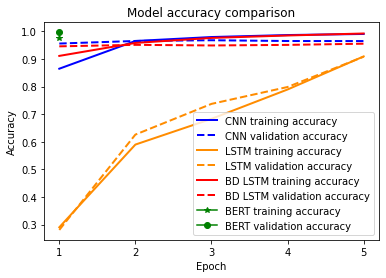

In [42]:
# plot learning curves
plt.figure()
plt.plot(history_cnn.history['accuracy'], color='blue', lw=2, label='CNN training accuracy')
plt.plot(history_cnn.history['val_accuracy'], color='blue', lw=2, linestyle='--', label='CNN validation accuracy')
plt.plot(history_lstm.history['accuracy'], color='darkorange', lw=2, label='LSTM training accuracy')
plt.plot(history_lstm.history['val_accuracy'], color='darkorange', lw=2, linestyle='--', label='LSTM validation accuracy')
plt.plot(history_bilstm.history['accuracy'], color='red', lw=2, label='BD LSTM training accuracy')
plt.plot(history_bilstm.history['val_accuracy'], color='red', lw=2, linestyle='--', label='BD LSTM validation accuracy')
plt.plot(0,history_HF.history['sparse_categorical_accuracy'], color='green', marker='*', label='BERT training accuracy')
plt.plot(0,history_HF.history['val_sparse_categorical_accuracy'], color='green', marker='o', label='BERT validation accuracy')
plt.title('Model accuracy comparison')
plt.xlabel('Epoch')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

The single-layer LSTM model has the steepest learning curve, and the worst performance at the end of its training in both validation and training accuracies.

The bidirectional LSTM however obtains better performances than both the single-layer LSTM and the CNN with a more consistent learning curve.

But the Transformer has the best performance from the start, in both training and validation accuracies.

## Prediction on a new complaint

Here we use all four models to predict the product category for a brand new complaint.

In [78]:
import numpy as np

text = "Unreachable customer service ! \n I do not know which is worse, the loan or the card application process. After months spent asking for the latter I now have no idea what stage my application is at. It is impossible to reach a human being and I have no idea if I eeeven got approved or not. \n It's been MONTHS! I need that money! \n That's unacceptable."
def handle_complaint(text, max_length):
    text1 = clean_text(text)
    text1 = [text1.split()]
    text1 = tokenizer.texts_to_sequences(text1)
    text1 = pad_sequences(text1,maxlen=max_length,padding='post')
    return(text1)

text_vect = handle_complaint(text, max_length)
text

"Unreachable customer service ! \n I do not know which is worse, the loan or the card application process. After months spent asking for the latter I now have no idea what stage my application is at. It is impossible to reach a human being and I have no idea if I eeeven got approved or not. \n It's been MONTHS! I need that money! \n That's unacceptable."

In [79]:
# CNN
proba_predict_cnn  = model_cnn.predict(text_vect)
print("CNN prediction: "+str(le.inverse_transform([np.argmax(proba_predict_cnn)])[0]))

# LSTM
proba_predict_lstm = model_lstm.predict(text_vect)
print("LSTM prediction: "+str(le.inverse_transform([np.argmax(proba_predict_lstm)])[0]))

# Bidirectional LSTM
proba_predict_bilstm = model_bilstm.predict(text_vect)
print("Bidirectional LSTM prediction: "+str(le.inverse_transform([np.argmax(proba_predict_bilstm)])[0]))

# BERT
text = [text] #brackets : compatible with transformer prediction
encodings_HF = tokenizer_HF(text, padding='max_length', truncation=True)
text_data_tf_HF = tf.data.Dataset.from_tensor_slices((dict(encodings_HF)))
preds_HF = model_HF.predict(text_data_tf_HF.batch(1)).logits
res_HF = tf.nn.softmax(preds_HF, axis=1).numpy()
print("BERT prediction : ", le_HF.inverse_transform([np.argmax(res_HF)]))

1/1 [==============================] - 0s 20ms/step
CNN prediction: Payday loan
1/1 [==============================] - 0s 22ms/step
LSTM prediction: Credit card
1/1 [==============================] - 0s 27ms/step
Bidirectional LSTM prediction: Credit card
1/1 [==============================] - 0s 90ms/step
BERT prediction :  ['Credit card']


The example text is a bit ambiguous, but all models except for the CNN picked up on the fact that it was about a credit card instead of a loan.

# Conclusion

Although the CNN is quite fast (fitting in under 5min), and has high accuracy, it does not handle new ambiguous text well.

The single-layer LSTM has the worst performance out of all four models. But the bidirectional LSTM manages to be on par with the CNN and generalises well to new unseen text. 

The transformer is by far the highest performer with over 99% accuracy, and it clearly picks up on ambiguity, but its long training time is a major drawback.

As a conclusion, the bidirectional LSTM seems to be the most efficient model, with very satisfying accuracy, short training time, and the ability to discern nuance in new text examples.